# Demo - Black Box Attack with CIFAR10

In [1]:
import os
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks
from torchattacks import PGD

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load CIFAR10 Data

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

batch_size = 24

cifar10_train = dsets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
cifar10_test  = dsets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=batch_size,
                                        shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

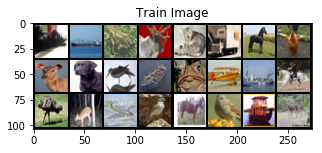

In [5]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## 2. Load Holdout Model & Save Adversarial Images

In [6]:
from models import Holdout
model = Holdout().cuda()
model.load_state_dict(torch.load("model/holdout.pth"))
model.eval()

Holdout(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=1600, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [7]:
pgd_attack = PGD(model, eps=0.3, alpha=2/255, iters=10)

# set_mode will change outputs into 'int' or 'float'.
# If you want to reduce the space of dataset, use set_mode('int').
pgd_attack.set_mode('int')
# pgd_attack.set_mode('float') 

# If you don't want to know the accuaracy, set accuracy as False.
pgd_attack.save(data_loader=test_loader, file_name="data/cifar10_pgd.pt", accuracy=True)

- Save Progress : 100.00 %        
- Accuracy of the model : 0.100000 %
- Save Complete!


## 3. Load Adversarial Images & Attack Target Model

In [8]:
adv_images, adv_labels = torch.load("./data/cifar10_pgd.pt")
adv_data = TensorDataset(adv_images.float()/255, adv_labels)
adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)

In [9]:
from models import Target
model = Target().cuda()
model.load_state_dict(torch.load("model/target.pth"))

<All keys matched successfully>

In [10]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy with Clean images: %f %%' % (100 * float(correct) / total))

Accuracy with Clean images: 77.770000 %


In [11]:
model.eval()

correct = 0
total = 0

for images, labels in adv_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy with Adversarial images: %f %%' % (100 * float(correct) / total))

Accuracy with Adversarial images: 26.500000 %
